## Swiss radar network overview
#### This notebook shows the code to plot the Swiss radar network overview

In [1]:
#load packages
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd 
import xarray as xr
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patheffects as patheffects
from matplotlib.patches import Patch
from pyproj import Transformer
from matplotlib import colors
import datetime as dt
import geopandas as gpd
import timeit
import cartopy.crs as ccrs
from shapely import wkt
import cartopy.feature as cf
import rioxarray as rxr
from climada import CONFIG
sys.path.append(str(CONFIG.local_data.func_dir))
import scClim.hail_climada as fct
import scClim as sc
from scClim.constants import ZRH_EXTENT, CMAP_VIR, CH_EXTENT_EPSG2056,ZRH_EXTENT_EPSG2056,CH_EXTENT,CANTON_DICT,PLOT_EXTENT_DICT,ID_COL_DICT

#The data directory is defined in the CLIMADA configuration file
data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)

Could not find bayes_opt. Module Calib_opt will not work.


In [2]:
#Define location of Swiss radars and save to pd.Dataframe
albis =         (47.284380558879924,    8.512012256288788)
monte_lema =    (46.0407749638419,      8.833287438635887)
plaine_morte =  (46.37066695182743,     7.48649280864315)
la_dole =       (46.425685686212404,    6.100087861038654)
weissfluh =     (46.83497304383815,     9.79458732101177)

radar_df = pd.DataFrame(index=['Albis','Monte Lema','Plaine Morte','La Dole','Weissfluh'],
                        columns=['lat','lon'],data=[albis,monte_lema,plaine_morte,la_dole,weissfluh])
radar_gdf = gpd.GeoDataFrame(radar_df,geometry=gpd.points_from_xy(radar_df.lon,radar_df.lat),crs='EPSG:4326')
radar_gdf['chx']= radar_gdf.geometry.to_crs('EPSG:2056').x
radar_gdf['chy']= radar_gdf.geometry.to_crs('EPSG:2056').y

In [ ]:
#Load a 2km reflecetivity CAPPI (name OZC) to define the radar range at 2km
from rasterio.enums import Resampling
#filname of 2km reflectivity CAPPI from MeteoSwiss
filename_2km = data_dir+'/V5/OZC/OZC_6t6_2021_2km.nc'

#Define projection
pr1 = ccrs.AlbersEqualArea(8.222665776, 46.800663464)
pr2 = ccrs.epsg(2056)

z_2km = xr.open_dataset(filename_2km)
z_2km = z_2km.rio.write_crs("EPSG:2056")
z_2km = z_2km.drop_vars(['lat','lon'])
#All cells with a maximum recorded reflectivity>-10 are within the 2km radar range
rad_range = (z_2km.OZC.max(dim='time')>-10).astype(float).to_dataset(name='rad_range_2km')

In [4]:
#create Dataset with all points <160km from any radar
x_coords, y_coords = np.meshgrid(rad_range.chx, rad_range.chy)
distances = np.ones_like(rad_range.rad_range_2km.values)*200000
for i in range(len(radar_gdf)):
    distances = np.minimum(distances,np.sqrt((x_coords - radar_gdf.iloc[i].chx)**2 +
                                             (y_coords -radar_gdf.iloc[i].chy)**2))
rad_range['distances'] = xr.DataArray(distances,dims=['chy','chx'],
                                      coords={'chy':rad_range.chy,'chx':rad_range.chx})
rad_range['rad_range_total'] = (rad_range.distances<=165000).astype(float)
#Note:  #choose 165 instead of 160 because in the 2km array values are saved up to 165km

In [5]:
#reproject to albers equal area
rad_range = rad_range.rio.reproject(pr1, shape=(1000, 1000), 
                                    resampling=Resampling.nearest, 
                                    nodata=np.nan)
rad_range = rad_range.drop_vars(['spatial_ref'])

In [ ]:
# read relief and data (with xr or rxr depending on the kernel version)
# Data source for Swiss relief: https://www.swisstopo.admin.ch/de/geodata/height/alti3d.html 
try:
    da_relief = xr.open_rasterio(data_dir+'/ch_shapefile/relief_georef_clipped_swiss.tif')
    relief_crs = da_relief.crs
except:
    da_relief = rxr.open_rasterio(data_dir+'/ch_shapefile/relief_georef_clipped_swiss.tif')
    relief_crs = da_relief.rio.crs
    
# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da_relief['y']), len(da_relief['x'])
x, y = np.meshgrid(da_relief['x'], da_relief['y'])
# Rasterio works with 1D arrays
outProj = 'epsg:4326' # WGS84, see https://epsg.io/4326
transformer = Transformer.from_crs(relief_crs, outProj)
lat, lon = transformer.transform(x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))-0.01
lat = np.asarray(lat).reshape((ny, nx))
da_relief.coords['lon'] = (('y', 'x'), lon)
da_relief.coords['lat'] = (('y', 'x'), lat)

# get band
da_relief = da_relief.isel(band=0, drop=True)
da_relief = da_relief.where(da_relief > 1, drop=True)

c:\Users\timo_\Anaconda3\envs\climada_rio\lib\site-packages\cartopy\mpl\feature_artist.py:149: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


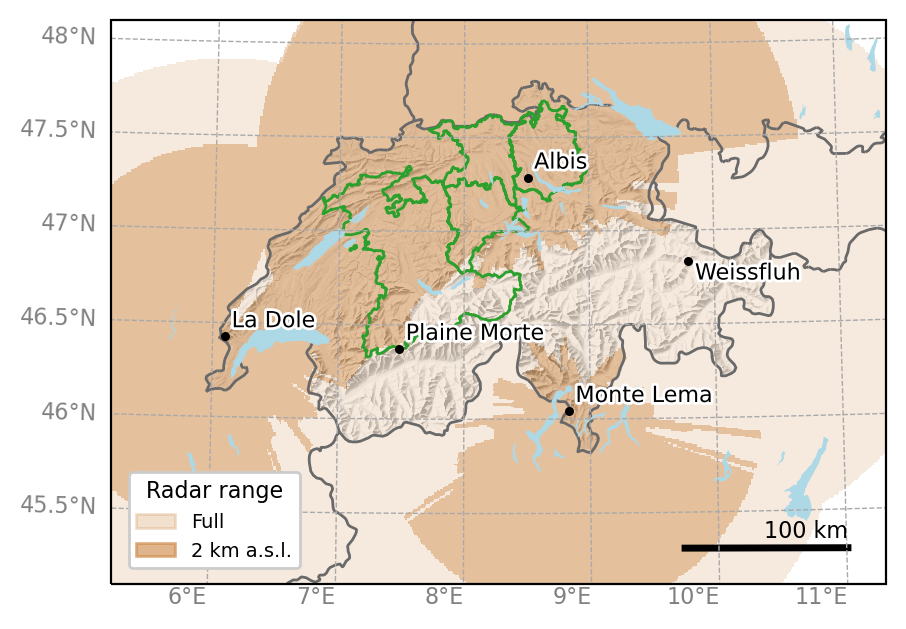

In [7]:
#Create plot
prj = ccrs.AlbersEqualArea(8.222665776, 46.800663464)
fig,ax = plt.subplots(1,1,figsize=(5,9),subplot_kw={'projection':prj},dpi=200)

#add relief
da_relief.plot(ax=ax, x='lon', y='lat', cmap="Greys_r",norm=colors.Normalize(vmin=110, vmax=255), 
               add_colorbar=False, transform=ccrs.PlateCarree(),zorder=0.5)

#add radar range
sc.plot_nc(rad_range.rad_range_total,ax=ax,crs=prj,vmax=1,vmin=0.8,cmap='peru',
           pl_type='bool_field',alpha=0.25,borders=False)
sc.plot_nc(rad_range.rad_range_2km,ax=ax,crs=prj,vmax=1,vmin=0.8,cmap='peru',
           pl_type='bool_field',alpha=0.35,border_color='dimgrey')

alphas = [0.25,0.6]; labels = ['Full','2 km a.s.l.']
lines = [Patch(color='peru',alpha=alphas[i]) for i in range(2)]
ax.legend(lines,labels,loc='lower left',bbox_to_anchor=(0.01,0.01),
          fontsize=7,framealpha=1,title='Radar range',title_fontsize=8)

#add cantons
sc.plot_canton(ax,canton=['Zürich','Aargau','Luzern','Bern'],
               facecolor='none',edgecolor='tab:green',zorder=2)

# #add names
transform = ccrs.PlateCarree()._as_mpl_transform(ax)
for i, label in enumerate(radar_df.index):
    y_shift = -0.15 if label=='Weissfluh' else 0
    ax.annotate(label, xy=(radar_df.lon[i], radar_df.lat[i]),
                xytext=(radar_df.lon[i]+0.05, radar_df.lat[i]+0.05+y_shift),
                xycoords=transform,fontsize=8,zorder=3,
                path_effects=[patheffects.withStroke(linewidth=2, foreground='white')])

ax.scatter(radar_df.lon,radar_df.lat,marker='.',color='black',s=20,
           transform=ccrs.PlateCarree(),zorder=3)

#add scalebar
scaleBar = Line2D((2780e3,2880e3),(1020e3,1022e3),transform = ccrs.epsg(2056),
                  color='black',linewidth=2.5) #+2km for p2, to receive horizontal line
ax.add_line(scaleBar)
ax.text(2880e3, 1025e3, '100 km', transform=ccrs.epsg(2056),fontsize=8,
        horizontalalignment='right',verticalalignment='bottom')

#set figure options and save the figure
gl=ax.gridlines(draw_labels=["bottom","left"], x_inline=False, y_inline=False,
                linestyle='--',linewidth=0.5,color='darkgrey',
                xlabel_style={'color':'grey','size':8,'rotation':'horizontal'},
                ylabel_style={'color':'grey','size':8})
ax.set_extent((5.25, 11.3, 45.1, 48.1),crs = ccrs.PlateCarree())
ax.set(title='')
fig.savefig(out_dir+'/paper1/fig01.png',bbox_inches='tight',dpi=300)